### GARCH Model (Generalized Autoregressive Conditional Heteroskedasticity)

##### What is it?
A GARCH model predicts **volatility** (how much a stock/asset's returns vary over time). It assumes today's volatility depends on past volatility and past shocks.

##### Key Idea
Volatility clusters - high volatility tends to follow high volatility, calm periods follow calm periods.


# Intraday Strategy Using Garch Model
.Using simulated daily data and intraday 5-min data.
.Load Daily and 5-minute data.

.Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.

Merge with intraday data and calculate intraday indicators to form intraday signal.

.Generate the position entry and hold until the end of the day.

.Calculate final strategy returns.

### 1.Load simulated daily and simulated 5-minute data.
.We are loading both datasets, set the indexes and calculate daily log returns.

In [2]:
import matplotlib.pyplot as plt
from arch import arch_model
from tqdm import tqdm
import pandas as pd
import numpy as np
np.NaN = np.nan  # Force alias for compatibility
import pandas_ta
import os

data_folder=r'C:\Users\Aissa\Downloads\unemployement no more'
daily_df = pd.read_csv(os.path.join(data_folder,'simulated_daily_data.csv'))
daily_df['Date']=pd.to_datetime(daily_df['Date'])
daily_df=daily_df.set_index(['Date'])
daily_df = daily_df.drop(columns=['Unnamed: 7'])
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()


intraday_5min_df = pd.read_csv(os.path.join(data_folder,'simulated_5min_data.csv'))
intraday_5min_df = intraday_5min_df.drop(columns=['Unnamed: 6'])
intraday_5min_df['datetime']= pd.to_datetime(intraday_5min_df['datetime'])
intraday_5min_df= intraday_5min_df.set_index(['datetime'])
intraday_5min_df['date']=pd.to_datetime(intraday_5min_df.index.date)
intraday_5min_df


,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


#### 2.Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window

.We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance

.Whenever we need to fit a GARCH model we need to supply the autoregressive and moving average orders(we need to find them using maybe a brute force to try to find the lowest error I found that the best garch model on this data is having autoregressive order = 1 and moving average order = 3) 

<Axes: xlabel='Date'>

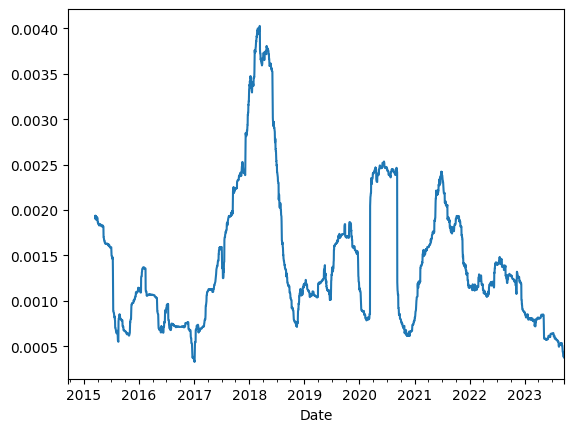

In [3]:
#rolling 6 month variance of the log return
daily_df['variance']= daily_df['log_ret'].rolling(180).var()
daily_df['variance'].plot()

In [4]:
def predict_volatility(x):
    best_model = arch_model(y=x,
                            p=1,
                            q=3,
                            rescale=False).fit(update_freq=5,disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    return variance_forecast
daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))
daily_df

c:\Users\Aissa\miniconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Aissa\miniconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Aissa\miniconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\Aissa\miniconda3\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  war

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,-0.074643,NaN,NaN
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,-0.072402,NaN,NaN
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,0.035111,NaN,NaN
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,-0.024968,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


<Axes: xlabel='Date'>

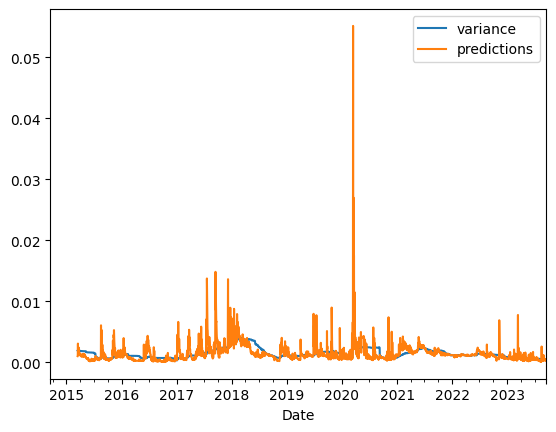

In [5]:
daily_df[['variance','predictions']].plot()

### 3.Calculate prediction premium and form a daily signal from it
.We calculate the prediction premium. And calculate its 6 month rolling standard deviation.

.From this we are creating our daily signal.

Intuition Behind the Strategy
Volatility Mispricing:
GARCH models predict future volatility based on past trends. If the prediction is too high/low compared to what actually happened (variance), it suggests a potential market inefficiency.

Threshold (1.5σ):
The 1.5x multiplier avoids over-trading by requiring deviations to be statistically significant (beyond typical noise).

Rolling Window (180 days):
Adapts to changing market regimes (e.g., periods of high/low volatility clustering).

 Example Scenario
Suppose for a given day:

prediction_premium = 0.2 (predicted volatility is 20% higher than realized).

premium_std = 0.1 (typical deviation is 10%).

Signal Calculation:

1.5 * premium_std = 0.15

Since 0.2 > 0.15 → Long Signal (1).

Action:
Buy volatility (e.g., call/put options, VIX futures) expecting a correction.


<Axes: ylabel='Frequency'>

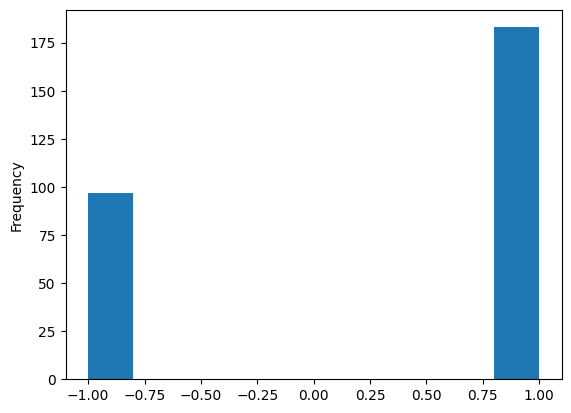

In [6]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']
daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()
daily_df['signal_daily'] = daily_df.apply(lambda x :1 if (x['prediction_premium'] > x['premium_std']*1.5)
                                          else (-1 if (x['prediction_premium'] < x['premium_std']*-1.5) else np.nan),
                                          axis=1)
daily_df['signal_daily']=daily_df['signal_daily'].shift()
daily_df['signal_daily'].plot(kind='hist')



<Axes: xlabel='Date'>

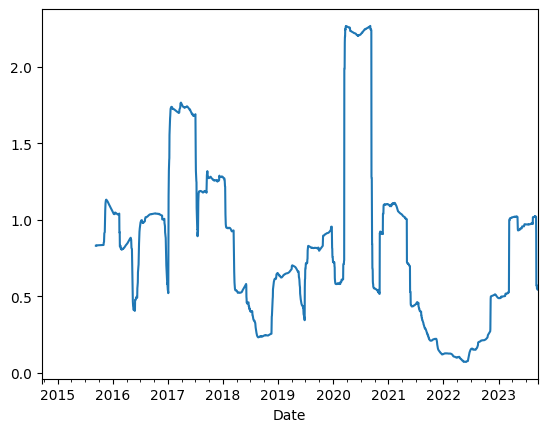

In [7]:
daily_df['premium_std'].plot()

### 4.Merge with intraday data and calculate intraday indicators to form the intraday signal
. Calculate all intraday indicators and intraday signal

In [8]:
final_df   = intraday_5min_df.reset_index()\
        .merge(daily_df[['signal_daily']].reset_index(),
         left_on='date',
         right_on='Date')\
         .set_index(['datetime'])
final_df= final_df.drop(['date','Date'], axis=1)
final_df

,open,low,high,close,volume,signal_daily
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN
...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN


In [9]:
#calculate indicators
final_df['rsi']=pandas_ta.rsi(close=final_df['close'],
                              length=20)
final_df['lowerband']=pandas_ta.bbands(close=final_df['close']
                                 ,length=20).iloc[:,0]
final_df['upperband']=pandas_ta.bbands(close=final_df['close']
                                 ,length=20).iloc[:,2]
final_df

,open,low,high,close,volume,signal_daily,rsi,lowerband,upperband
datetime,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084
